## Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

### Описание проекта

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. \
Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. \
Постройте модель для такого предсказания.

### План работы:

- Загрузка и предобработка проекта
- анализ данных
- обучение модели
- проверка на тестовой выборке
- общий вывод 

### Подготовка данных

#### Загрузка необходимых библиотек

In [1]:
import sys
!{sys.executable} -m pip install -U lightgbm -q

In [34]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from typing import Optional
from statsmodels.tsa.seasonal import seasonal_decompose

import lightgbm as lgb
from lightgbm import LGBMRegressor

from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, TimeSeriesSplit
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler, KBinsDiscretizer

import warnings
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore', category=UserWarning)

#### Загрузка датасета

In [3]:
# адреса расположения датасета
HOME_PATH = 'taxi.csv'
SERVER_PATH = '/datasets/taxi.csv'

if os.path.exists(HOME_PATH):
    df = pd.read_csv(HOME_PATH, parse_dates=['datetime'], index_col='datetime')
elif os.path.exists(SERVER_PATH):
    df = pd.read_csv(SERVER_PATH, parse_dates=['datetime'], index_col='datetime')

#### Функция для анализа данных 

In [4]:
def inform(data):
    # Вывод информации о датасете
    print("Информация о датасете:")
    data.info()
    
    # Разделительная строка
    print("\n" + "="*50 + "\n")
    
    # Вывод первых нескольких строк датасета
    print("Первые несколько строк датасета:")
    display(data.head())
    
    # Разделительная строка
    print("\n" + "="*50 + "\n")
    
    #describe
    print('Описательная статистика:')
    display(data.describe())

    # Разделительная строка
    print("\n" + "="*50 + "\n")

    print('гистограмма численных показателей')
    data.hist(figsize=(9, 6), bins=50)

#### Функция разбития на признаки

In [24]:
def make_features(df, max_lag, window_size):
    df_new = df.copy()
    
    # Отстающие (предыдущие) признаки / lag features
    for lag in range(1, max_lag+1):
        # Применяем shift с заполнением пропущенных значений нулями
        df_new['num_orders_{}'.format(lag)] = df_new['num_orders'].shift(periods=lag).fillna(0)
    
    # Скользящее среднее / rolling mean
    df_new['rolling_mean'] = df_new['num_orders'].shift().rolling(window_size).mean()
    
    # Стандартное отклонение / std factor
    df_new['std_factor'] = df_new['num_orders'].shift().rolling(window_size).std()
    
    # Календарные признаки / calendar features
    df_new['month']     = df_new.index.month
    df_new['dayofweek'] = df_new.index.dayofweek
    df_new['day']       = df_new.index.day
    df_new['hour']      = df_new.index.hour
    
    df_new.dropna(inplace=True)
    
    return df_new

#### Общий анализ

Информация о датасете:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


Первые несколько строк датасета:


,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32




Описательная статистика:


,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000




гистограмма численных показателей


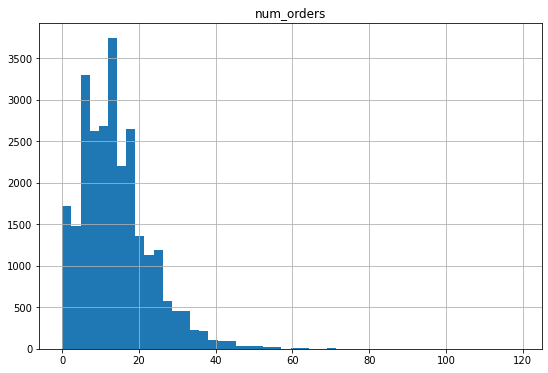

In [6]:
inform(df)

**Промежуточный вывод:** как мы видим, нам предоставлена статистика поездок с разбитием на даты.\
На основе описательной статистики мы видим, что в предоставленных данных количество поездок разнится от 0 до 119 поездок.\
На основе графика мы видим, что 0 поездок - это не еденичноен исключение и общий показатель по поездкам в минимальном количестве переваливает за 20 в месяц

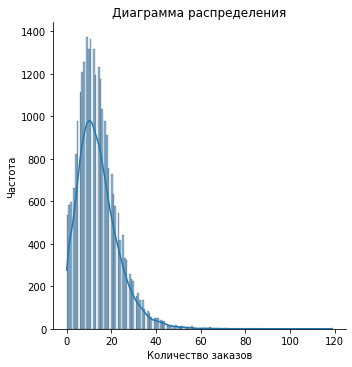

In [7]:
heatmap_data = df.resample('M')['num_orders'].sum().to_frame().unstack(level=0)

# Диаграмма распределения
sns.displot(df['num_orders'], kde=True)
plt.title('Диаграмма распределения')
plt.xlabel('Количество заказов')
plt.ylabel('Частота')
plt.show()

**Промежуточный вывод:** на основе графиков выше мы можем уточнить данные, а именно
 - Максимальное количество поездок в месяц было в августе, в остальных месяцах более 40 поездок в день- явное исключение из правил
 - Частота поездок в районе 10 демонстрирует наибольшую частоту в предоставленных данных
 - По диаграмме распределения мы подтверждаем вышеописанное и видим выбросыЮ с которыми нам придётся иметь дело

Возможны три варианта устранение выбросов:

- Сначала избавить исходные данные от эти объектов, а после выполнить необходимую процедуру ресемплинга и продолжить работу.
- Наоборот: Сначала выполнить ресемплинг, поскольку при объединении шести записей в одну происходит аппроксимация (усреднение). Завышенные значения могут быть компенсированы заниженными значениями, расположенных по соседству.
- Поскольку выбросами являются объекты с повышенным числом заказов, то следует избавиться именно от той части заказов, которая "свыше обычной нормы". Заменить выбросы на максимальное значение, в пределах нормального распределения.
- Альтернативный вариант: замена на среднее значение.

In [8]:
# Вычислим 95% процентиль для выбросов
percentile_95 = df['num_orders'].quantile(0.95)
print(f"95-й процентиль для столбца num_orders: {percentile_95}")

95-й процентиль для столбца num_orders: 31.0


Учитывая, что 95% процентиль останавливается на значении 31, а сравнительно много значений у нас вплоть до 40-45 с множеством единичных впоть до 119, пойдём по пути первоначального ресемплинга

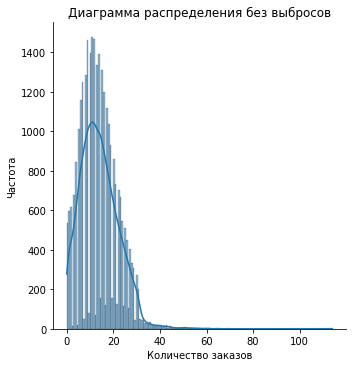

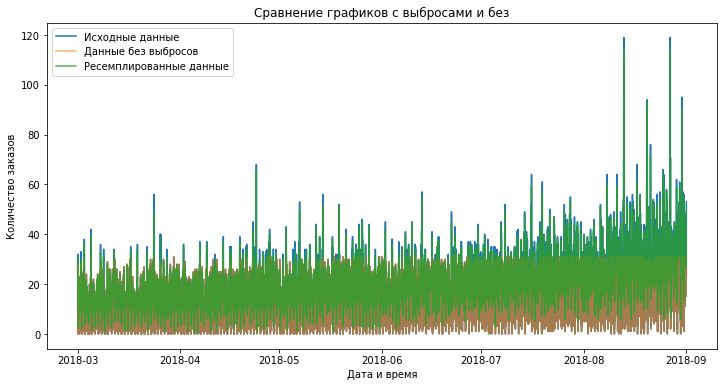

In [9]:
resampled_df = df.resample('1H').agg({'num_orders': lambda x: x.quantile(0.95)})

# Копия без выбросов
df_no_outliers = df.copy()
df_no_outliers = df_no_outliers[df_no_outliers['num_orders'] <= percentile_95]

# Единый датафрейм без выбросов
df_combined_resampled = pd.concat([resampled_df, df_no_outliers], ignore_index=False)

# Диаграмма распределения без выбросов
sns.displot(df_combined_resampled['num_orders'], kde=True)
plt.title('Диаграмма распределения без выбросов')
plt.xlabel('Количество заказов')
plt.ylabel('Частота')
plt.show()

# Линейный график сравнения с выбросами и без
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['num_orders'], label='Исходные данные')
plt.plot(df_no_outliers.index, df_no_outliers['num_orders'], label='Данные без выбросов', alpha=0.6)
plt.plot(resampled_df.index, resampled_df['num_orders'], label='Ресемплированные данные', alpha=0.8)
plt.legend()
plt.xlabel('Дата и время')
plt.ylabel('Количество заказов')
plt.title('Сравнение графиков с выбросами и без')
plt.show()

In [10]:
# сравнительная таблица статистических значений
df_2 = df.describe().add_suffix('_original')
df_combined_resampled_2 = df_combined_resampled.describe().add_suffix('_no_outliers')

combined_desc = df_2.join(df_combined_resampled_2, lsuffix='_original', rsuffix='_no_outliers')
display(combined_desc)

,num_orders_original,num_orders_no_outliers
count,26496.000000,29692.000000
mean,14.070463,13.982849
std,9.211330,8.200632
min,0.000000,0.000000
25%,8.000000,8.000000
50%,13.000000,13.000000
75%,19.000000,19.000000
max,119.000000,114.000000


Для сравнения изучим метод с усреднением значений

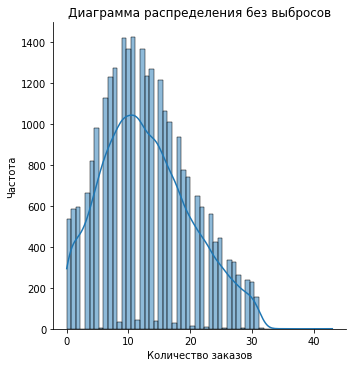

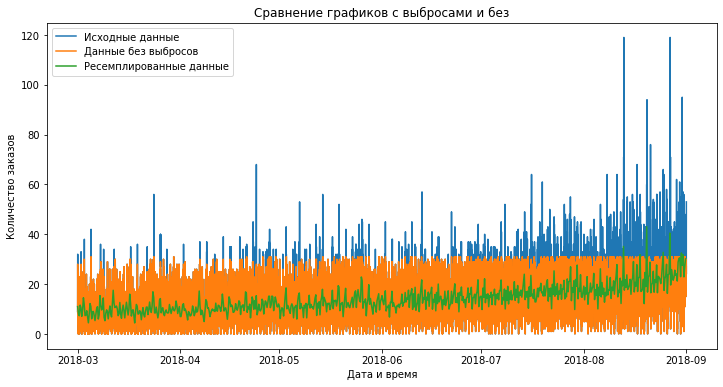

In [11]:
resampled_df_2 = df.resample('6H').agg({'num_orders': 'mean'})

# Копия без выбросов
df_no_outliers_2 = df.copy()
df_no_outliers_2 = df_no_outliers_2[df_no_outliers_2['num_orders'] <= percentile_95]

# Единый датафрейм без выбросов
df_combined_mean = pd.concat([resampled_df_2, df_no_outliers_2], ignore_index=False)

# Диаграмма распределения без выбросов
sns.displot(df_combined_mean['num_orders'], kde=True)
plt.title('Диаграмма распределения без выбросов')
plt.xlabel('Количество заказов')
plt.ylabel('Частота')
plt.show()

# Линейный график сравнения с выбросами и без
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['num_orders'], label='Исходные данные')
plt.plot(df_no_outliers_2.index, df_no_outliers_2['num_orders'], label='Данные без выбросов')
plt.plot(resampled_df_2.index, resampled_df_2['num_orders'], label='Ресемплированные данные')
plt.legend()
plt.xlabel('Дата и время')
plt.ylabel('Количество заказов')
plt.title('Сравнение графиков с выбросами и без')
plt.show()

In [12]:
# сравнительная таблица статистических значений
df_combined_mean_2 = df_combined_resampled.describe().add_suffix('_no_outliers')

combined_desc = df_2.join(df_combined_mean_2, lsuffix='_original', rsuffix='_no_outliers')
display(combined_desc)

,num_orders_original,num_orders_no_outliers
count,26496.000000,29692.000000
mean,14.070463,13.982849
std,9.211330,8.200632
min,0.000000,0.000000
25%,8.000000,8.000000
50%,13.000000,13.000000
75%,19.000000,19.000000
max,119.000000,114.000000


Как мы видим - визуально результаты стали менее информативны

Причин проверять удаление перед ресемплингом и приведение всех данных свыше 31 к 31 я не вижу, поэтому остановмимся на варианте с первоначальным ресемплингом для чистки выбросов

#### Анализ данных

##### Общие графики

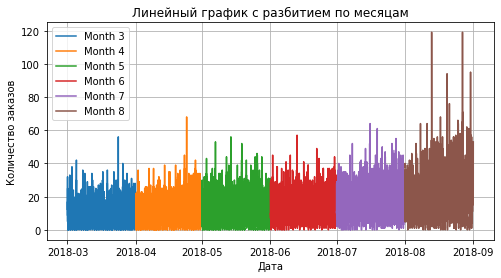

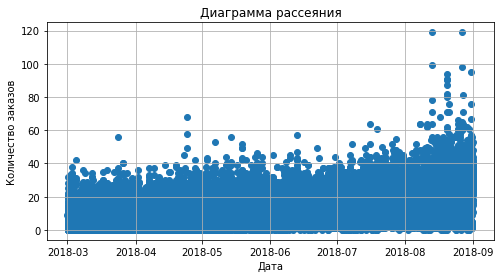

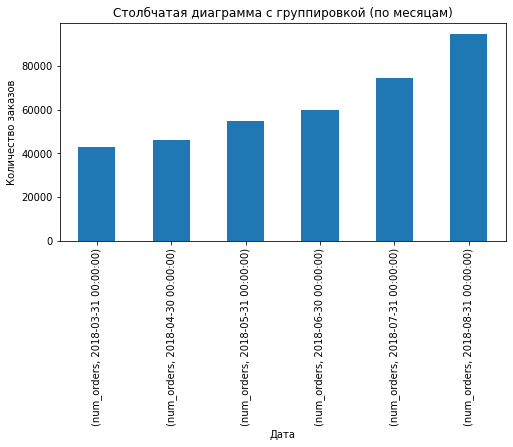

In [13]:
# Линейный график с разделением по категориям (по месяцам)
plt.figure(figsize=(8, 4))
for month in df.index.month.unique():
    plt.plot(df.index[df.index.month == month], df['num_orders'][df.index.month == month], label=f'Month {month}')
plt.xlabel('Дата')
plt.ylabel('Количество заказов')
plt.title('Линейный график с разбитием по месяцам')
plt.legend()
plt.grid(True)
plt.show()

# Диаграмма рассеяния
plt.figure(figsize=(8, 4))
plt.scatter(df.index, df['num_orders'])
plt.xlabel('Дата')
plt.ylabel('Количество заказов')
plt.title('Диаграмма рассеяния')
plt.grid(True)
plt.show()

# Столбчатая диаграмма с группировкой (по месяцам)
plt.figure(figsize=(8, 4))
heatmap_data.plot(kind='bar', stacked=True)
plt.title('Столбчатая диаграмма с группировкой (по месяцам)')
plt.xlabel('Дата')
plt.ylabel('Количество заказов')
plt.show()

##### seasonal_decompose

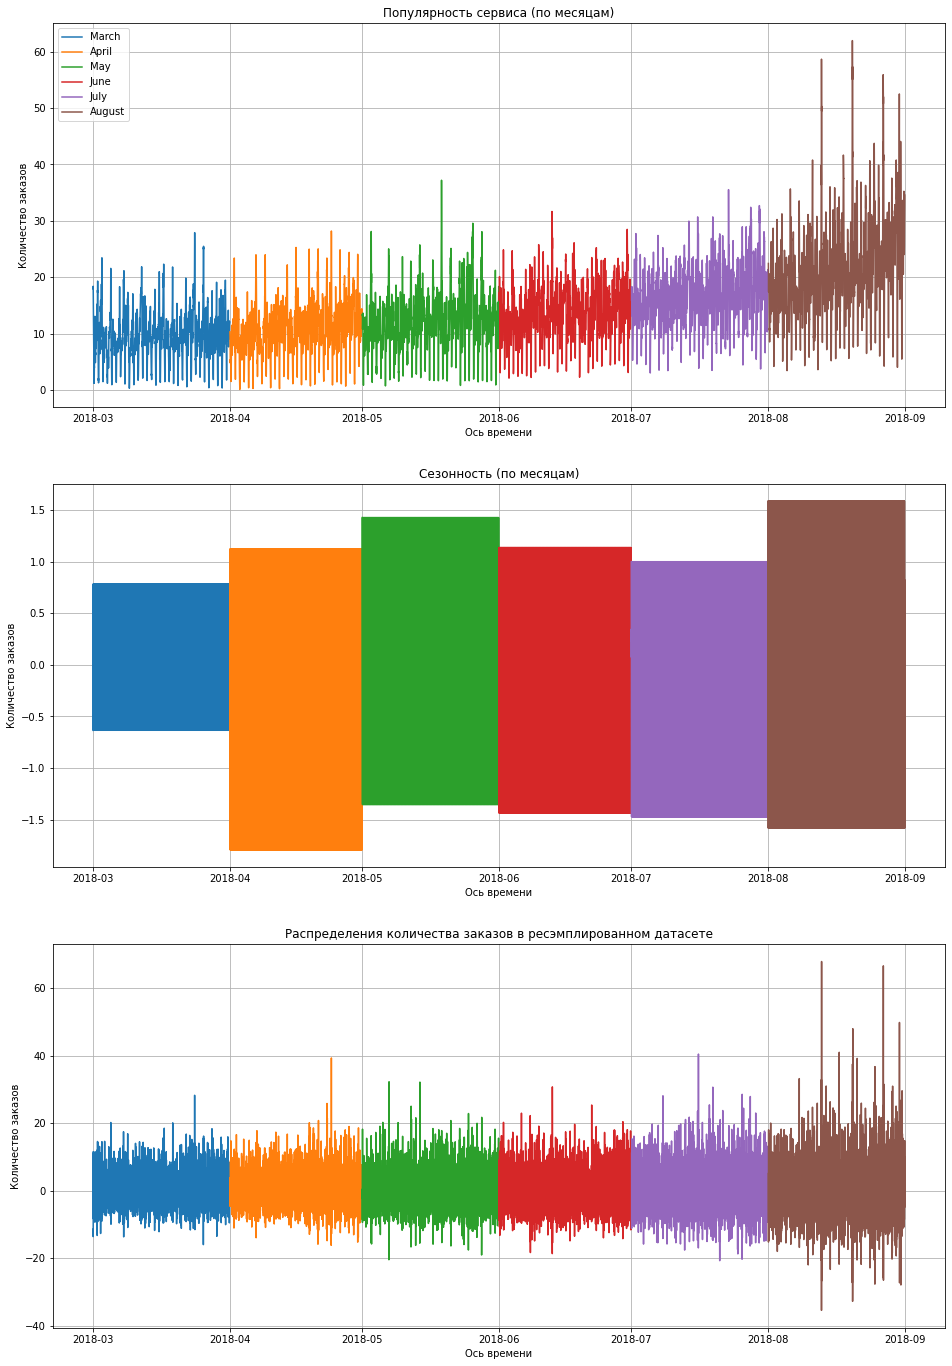

,March,April,May,June,July,August
count,4464.000000,4320.000000,4464.000000,4320.000000,4464.000000,4464.000000
mean,9.580645,10.634028,12.280466,13.867130,16.667787,21.275314
std,6.411901,6.926271,7.607219,7.354669,8.414885,11.901254
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5.000000,6.000000,7.000000,9.000000,11.000000,13.000000
50%,9.000000,10.000000,11.000000,13.000000,16.000000,20.000000
75%,13.000000,15.000000,16.000000,18.000000,22.000000,27.000000
max,56.000000,68.000000,56.000000,57.000000,64.000000,119.000000


In [14]:
describe_table = pd.DataFrame(index=df.describe().index)

fig, axs = plt.subplots(3, 1, figsize=(16, 24))
month_names = []

for month in df.index.month.unique():
    month_data = df[df.index.month == month]
    describe_table = describe_table.join(month_data.describe(), rsuffix=str(month))

    name = month_data.index[0].strftime('%B')
    month_names.append(name)
    
    decomposed_month = seasonal_decompose(month_data, model='additive', period=12)
    
    axs[0].plot(decomposed_month.trend.rename(name))
    axs[1].plot(decomposed_month.seasonal.rename(name))
    axs[2].plot(decomposed_month.resid.rename(name))

axs[0].set_title('Популярность сервиса (по месяцам)')
axs[0].set_ylabel('Количество заказов')
axs[0].set_xlabel('Ось времени')
axs[0].legend(month_names)
axs[0].grid()

axs[1].set_title('Сезонность (по месяцам)')
axs[1].set_ylabel('Количество заказов')
axs[1].set_xlabel('Ось времени')
axs[1].grid()

axs[2].set_title('Распределения количества заказов в ресэмплированном датасете')
axs[2].set_ylabel('Количество заказов')
axs[2].set_xlabel('Ось времени')
axs[2].grid()
plt.show()

describe_table.columns = month_names
display(describe_table)

На основе графиков можно сделать следующие выводы:
- К концу недели (пт и сб), независимо от месяца, число заказов наиболее высокое
- Наибольшее число заказов было в августе
- В марте и июне данные симметричны - среднее значение, отклонение и присутствие смещением минимальны
- В апреле и июле наблюдается смещение в меньшую сторону
- В мае и августе - смещение в большую

Учитывая, что графики отображают не абсолютную величину заказов, а только их часть (трендовую, сезонную и остаточную), \
то мы можем только предположить величину нетипичных заказов, которые могут возникать не предсказуемо.\
По этой причине графики могут иметь отрицательные значения. \
А так же могу быть расположенными симметрично относительно нуля, который на самом деле является средним значением за месяц.

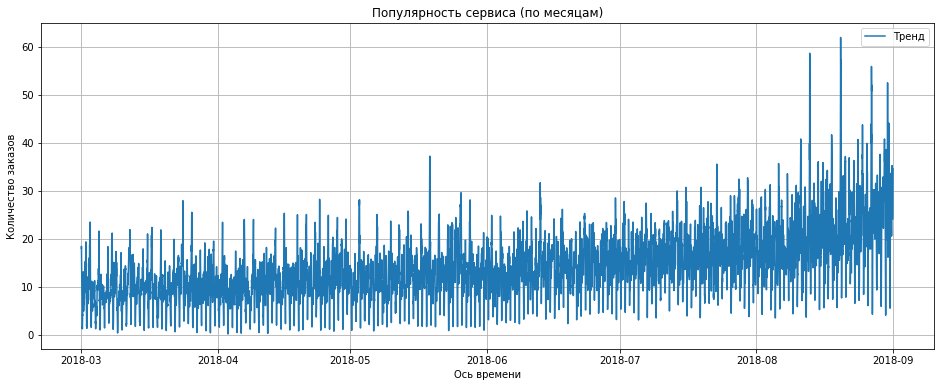

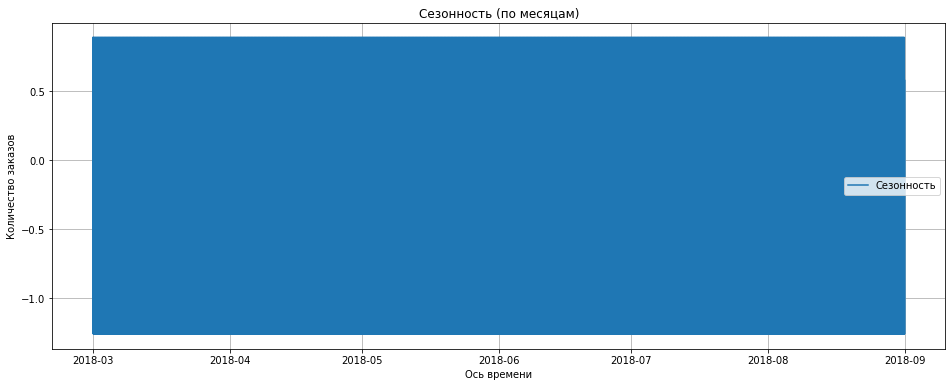

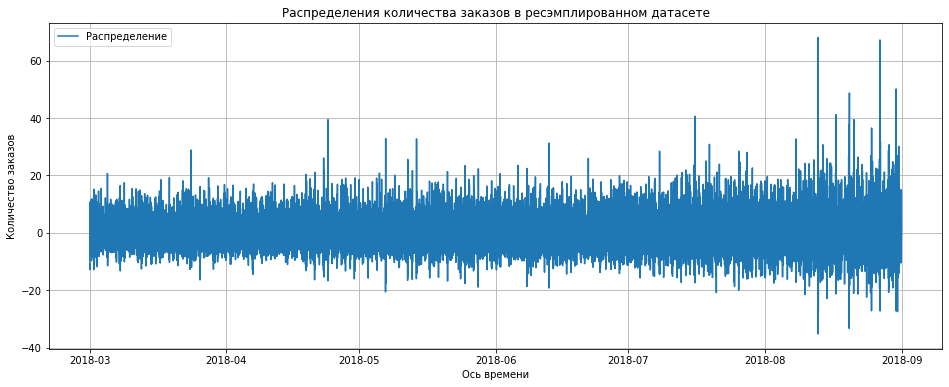

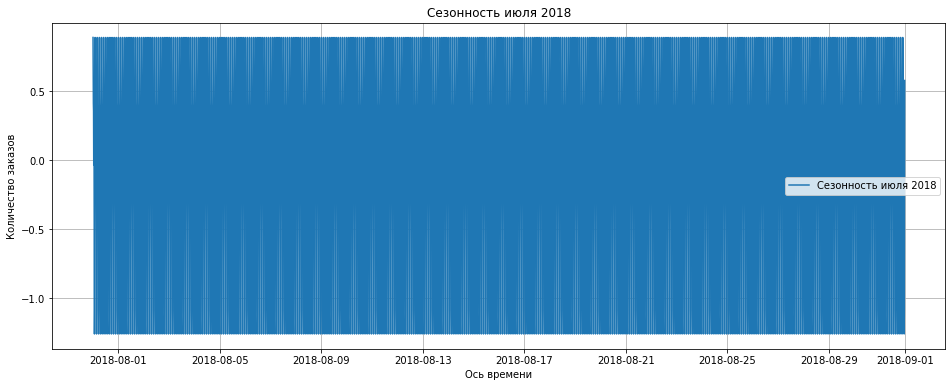

In [15]:
# Декомпозиция всего ряда данных
decomposed_data = seasonal_decompose(df, model='additive', period=12)

# Популярность сервиса (по месяцам)
plt.figure(figsize=(16, 6))
plt.plot(decomposed_data.trend, label='Тренд')
plt.title('Популярность сервиса (по месяцам)')
plt.xlabel('Ось времени')
plt.ylabel('Количество заказов')
plt.legend()
plt.grid()
plt.show()

# Сезонность (по месяцам)
plt.figure(figsize=(16, 6))
plt.plot(decomposed_data.seasonal, label='Сезонность')
plt.title('Сезонность (по месяцам)')
plt.xlabel('Ось времени')
plt.ylabel('Количество заказов')
plt.legend()
plt.grid()
plt.show()

# Распределения количества заказов в ресэмплированном датасете
plt.figure(figsize=(16, 6))
plt.plot(decomposed_data.resid, label='Распределение')
plt.title('Распределения количества заказов в ресэмплированном датасете')
plt.xlabel('Ось времени')
plt.ylabel('Количество заказов')
plt.legend()
plt.grid()
plt.show()

# Изучение сезонности для конкретного месяца
seasonal_data = decomposed_data.seasonal['2018-07-31':'2018-08-31']

plt.figure(figsize=(16, 6))
plt.plot(seasonal_data, label='Сезонность июля 2018')
plt.title('Сезонность июля 2018')
plt.xlabel('Ось времени')
plt.ylabel('Количество заказов')
plt.legend()
plt.grid()
plt.show()


##### Добавление признаков

Поскольку наш датафрейм состоит только из одной колонки, произведем разбиение datetime и кол-во заказов на новые данные для осуществоения возможности проведения обучения.

Из количества заказов будут выделены следующие признаки:
- **Отстающие признаки (lag features)**: Это количество заказов за предыдущие 6 часов.
- **Скользящее среднее (rolling mean)**: Это среднее количество заказов за несколько ближайших часов. Размер окна для скользящего среднего выбирается в зависимости от данных.

Из момента времени (индекса) будут выделены следующие календарные признаки:
- **Месяц**: Нужен для учета сезонности, поскольку количество заказов может варьироваться в зависимости от месяца.
- **День месяца**: Позволяет учесть дневные паттерны, такие как выходные или праздничные дни.
- **День недели**: Информативен для учета недельной сезонности.
- **Час**: Важен для анализа временных трендов и паттернов поведения пользователей.

Дополнительно к выбранным факторам, рассмотрим следующие признаки:
- **Фактор std**: Может быть полезен для учета разброса заказов, что может указывать на уровень активности или изменения в поведении пользователей.

Эти дополнительные признаки могут значительно улучшить качество прогнозов, позволяя модели учесть более широкий спектр факторов, влияющих на количество заказов.

In [26]:
df_combined_resampled_2 = make_features(df_combined_resampled, max_lag=24, window_size=12)
df_combined_resampled_2.info()
df_combined_resampled_2.head(5)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 29680 entries, 2018-03-01 12:00:00 to 2018-08-31 23:30:00
Data columns (total 31 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   num_orders     29680 non-null  float64
 1   num_orders_1   29680 non-null  float64
 2   num_orders_2   29680 non-null  float64
 3   num_orders_3   29680 non-null  float64
 4   num_orders_4   29680 non-null  float64
 5   num_orders_5   29680 non-null  float64
 6   num_orders_6   29680 non-null  float64
 7   num_orders_7   29680 non-null  float64
 8   num_orders_8   29680 non-null  float64
 9   num_orders_9   29680 non-null  float64
 10  num_orders_10  29680 non-null  float64
 11  num_orders_11  29680 non-null  float64
 12  num_orders_12  29680 non-null  float64
 13  num_orders_13  29680 non-null  float64
 14  num_orders_14  29680 non-null  float64
 15  num_orders_15  29680 non-null  float64
 16  num_orders_16  29680 non-null  float64
 17  num_orders_17  

,num_orders,num_orders_1,num_orders_2,num_orders_3,num_orders_4,num_orders_5,num_orders_6,num_orders_7,num_orders_8,num_orders_9,...,num_orders_21,num_orders_22,num_orders_23,num_orders_24,rolling_mean,std_factor,month,dayofweek,day,hour
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 12:00:00,10.25,22.75,16.50,18.50,8.75,6.25,5.75,2.75,16.00,19.25,...,0.0,0.0,0.0,0.0,16.020833,8.526335,3,3,1,12
2018-03-01 13:00:00,9.00,10.25,22.75,16.50,18.50,8.75,6.25,5.75,2.75,16.00,...,0.0,0.0,0.0,0.0,14.291667,7.215697,3,3,1,13
2018-03-01 14:00:00,15.25,9.00,10.25,22.75,16.50,18.50,8.75,6.25,5.75,2.75,...,0.0,0.0,0.0,0.0,13.083333,6.731315,3,3,1,14
2018-03-01 15:00:00,18.25,15.25,9.00,10.25,22.75,16.50,18.50,8.75,6.25,5.75,...,0.0,0.0,0.0,0.0,12.583333,6.277063,3,3,1,15
2018-03-01 16:00:00,8.75,18.25,15.25,9.00,10.25,22.75,16.50,18.50,8.75,6.25,...,0.0,0.0,0.0,0.0,12.500000,6.186496,3,3,1,16


#### Обучение моделей

- Обучим разные модели с различными гиперпараметрами. 
- Сделаем тестовую выборку размером 10% от исходных данных.

целевой признак - df_combined_mean['num_orders']

Выбранные к обучению модели:
- dummy
- Линейная регрессия
- Градиентный бустинг
- LightGBM

In [30]:
X = df_combined_resampled_2.drop('num_orders', axis=1)
y = df_combined_resampled_2['num_orders']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, shuffle=False)

continuous_features = df_combined_resampled_2.select_dtypes(include=['int', 'float']).columns.drop('num_orders')
# Числовые признаки
continuous_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('discretizer', KBinsDiscretizer(encode='onehot', strategy='uniform'))
])

# Единый препроцессор
preprocessor = ColumnTransformer([
    ('continuous', continuous_pipeline, continuous_features)
], remainder='passthrough')


##### Scorer

In [35]:
rmse_scorer = make_scorer(lambda y, y_pred: np.sqrt(mean_squared_error(y, y_pred)), greater_is_better=False)

tscv = TimeSeriesSplit(n_splits=5)

##### Linear Regressor

In [36]:
model_pipeline_lr = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression(n_jobs=-1))
])

# Настройка поиска по сетке
param_grid_lr = {
    'regressor__fit_intercept': [True, False]
}

gs_lr = GridSearchCV(model_pipeline_lr, param_grid_lr, scoring=rmse_scorer, cv=tscv, error_score='raise')
gs_lr.fit(X_train, y_train)

best_estimator_lr = gs_lr.best_estimator_
print("Best model for Linear Regressor:", best_estimator_lr)

rmse_scores_lr = -gs_lr.best_score_
print(f"RMSE on cross-validation for Linear Regressor: {rmse_scores_lr}")

start_time = time.time()
best_estimator_lr.fit(X_train, y_train)
fit_time_lr = round((time.time() - start_time)/60, 2)
print(f"Time for Linear Regressor on fit: {fit_time_lr} min")

start_time = time.time()
predictions = best_estimator_lr.predict(X_train)
predict_time_lr = round(time.time() - start_time, 2)
print(f"Time for Linear Regressor on predict: {predict_time_lr} seconds")

Best model for Linear Regressor: Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('continuous',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler()),
                                                                  ('discretizer',
                                                                   KBinsDiscretizer(strategy='uniform'))]),
                                                  Index(['num_orders_1', 'num_orders_2', 'num_orders_3', 'num_orders_4',
       'num_orders_5', 'num_orders_6', 'num_orders_7', 'num_orde...
       'num_orders_9', 'num_orders_10', 'num_orders_11', 'num_orders_12',
       'num_orders_13', 'num_or

##### Gradient Boosting Regressor

In [37]:
# Создание пайплайна для градиентного бустинга
model_pipeline_gb = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', GradientBoostingRegressor(random_state=42, n_estimators=100))
])

# Настройка поиска по сетке для градиентного бустинга
param_grid_gb = {
    'regressor__learning_rate': [0.01, 0.1, 0.2],
    'regressor__max_depth': [3, 4, 5],
    'regressor__min_samples_split': [2, 3, 4],
    'regressor__min_samples_leaf': [1, 2, 3],
    'preprocessor__n_jobs': [-1]
}

gs_gb = GridSearchCV(model_pipeline_gb, param_grid_gb, scoring=rmse_scorer, cv=tscv, error_score='raise')
gs_gb.fit(X_train, y_train)

best_estimator_gb = gs_gb.best_estimator_
print("Best model for Gradient Boosting Regressor:", best_estimator_gb)

rmse_scores_gb = -gs_gb.best_score_
print(f"RMSE on cross-validation for Gradient Boosting Regressor: {rmse_scores_gb}")

start_time = time.time()
best_estimator_gb.fit(X_train, y_train)
fit_time_gb = round((time.time() - start_time)/60, 2)
print(f"Time for Gradient Boosting Regressor on fit: {fit_time_gb} min")

start_time = time.time()
predictions = best_estimator_gb.predict(X_train)
predict_time_gb = round(time.time() - start_time, 2)
print(f"Time for Gradient Boosting Regressor on predict: {predict_time_gb} seconds")

Best model for Gradient Boosting Regressor: Pipeline(steps=[('preprocessor',
                 ColumnTransformer(n_jobs=-1, remainder='passthrough',
                                   transformers=[('continuous',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler()),
                                                                  ('discretizer',
                                                                   KBinsDiscretizer(strategy='uniform'))]),
                                                  Index(['num_orders_1', 'num_orders_2', 'num_orders_3', 'num_orders_4',
       'num_orders_5', 'num_orders_6', 'num_orders_7'...
       'num_orders_13', 'num_orders_14', 'num_orders_15', 'num_orders_16',
       'num_orders_

##### LGBMRegressor

In [38]:
model_pipeline_lgb = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LGBMRegressor(random_state = 42, force_col_wise=True))
])

# Настройка поиска по сетке
param_grid_lgb = {
    'regressor__num_leaves': [10, 20, 30],
    'regressor__learning_rate': [0.1, 0.2, 0.3],
    'regressor__n_estimators': [10, 20, 30, 40],
    'preprocessor__n_jobs': [-1]
}

gs_lgb = GridSearchCV(model_pipeline_lgb, param_grid_lgb, cv=tscv, scoring=rmse_scorer)

start_time = time.time()
gs_lgb.fit(X_train, y_train)

best_estimator_lgb = gs_lgb.best_estimator_
print("Best model for LightGBM:", best_estimator_lgb)

fit_time_lgb = round((time.time() - start_time)/60, 2)
print(f"Time for LightGBM on fit: {fit_time_lgb} min")

rmse_scores_lgb = -gs_lgb.best_score_
print(f"RMSE on cross-validation for LightGBM: {rmse_scores_lgb}")

start_time = time.time()
predictions = best_estimator_lgb.predict(X_train)
predict_time_lgb = time.time() - start_time
print(f"Time for LightGBM on predict: {predict_time_lgb} seconds")

[LightGBM] [Info] Total Bins 204
[LightGBM] [Info] Number of data points in the train set: 4452, number of used features: 102
[LightGBM] [Info] Start training from score 20.310085
[LightGBM] [Info] Total Bins 204
[LightGBM] [Info] Number of data points in the train set: 8904, number of used features: 102
[LightGBM] [Info] Start training from score 14.863039
[LightGBM] [Info] Total Bins 204
[LightGBM] [Info] Number of data points in the train set: 13356, number of used features: 102
[LightGBM] [Info] Start training from score 13.363619
[LightGBM] [Info] Total Bins 204
[LightGBM] [Info] Number of data points in the train set: 17808, number of used features: 102
[LightGBM] [Info] Start training from score 13.019121
[LightGBM] [Info] Total Bins 204
[LightGBM] [Info] Number of data points in the train set: 22260, number of used features: 102
[LightGBM] [Info] Start training from score 13.136770
[LightGBM] [Info] Total Bins 204
[LightGBM] [Info] Number of data points in the train set: 4452, 

#### Dummy regression

In [39]:
# Сравнение с DummyRegressor
start_time = time.time()
dummy_regressor = DummyRegressor(strategy='mean')
dummy_regressor.fit(X_train, y_train)
fit_time_dr = round((time.time() - start_time) / 60, 2)

start_time = time.time()
y_pred_dummy = dummy_regressor.predict(X_train)
end_time_ = time.time()
predict_time_dr = round(end_time_ - start_time,2)

rmse_dummy = np.sqrt(mean_squared_error(y_train, y_pred_dummy))
print(f"Dummy Regressor RMSE: {rmse_dummy}")

Dummy Regressor RMSE: 8.178046848007753


## Анализ моделей

### Определение лучшей модели по RMSE

In [40]:
rmse_scores = {
    'Linear Regression': rmse_scores_lr,
    'Gradient Boosting': rmse_scores_gb,
    'LightGBM': rmse_scores_lgb,
    'Dummy Regressor': rmse_dummy
}

fit_time = {
    'Linear Regression': fit_time_lr,
    'Gradient Boosting': fit_time_gb,
    'LightGBM': fit_time_lgb
}

score_time = {
    'Linear Regression': predict_time_lr,
    'Gradient Boosting': predict_time_gb,
    'LightGBM': predict_time_lgb
}

# Вычисление лучшей модели по RMSE
best_model_by_rmse = min(rmse_scores, key=rmse_scores.get)
print(f"Best model by RMSE: {best_model_by_rmse}")

# Вычисление лучшей модели по времени обучения
best_model_by_fit_time = min(fit_time, key=fit_time.get)
print(f"Best model by fit time: {best_model_by_fit_time}")

# Вычисление лучшей модели по времени предсказания
best_model_by_score_time = min(score_time, key=score_time.get)
print(f"Best model by score time: {best_model_by_score_time}")

best_model_name = best_model_by_rmse
if rmse_scores[best_model_by_rmse] == rmse_scores[best_model_by_fit_time]:
    best_model_name = best_model_by_fit_time
print(f"Best model overall: {best_model_name}")

Best model by RMSE: Gradient Boosting
Best model by fit time: Gradient Boosting
Best model by score time: LightGBM
Best model overall: Gradient Boosting


In [41]:
if best_model_name == 'Linear Regression':
    best_model = model_pipeline_lr
    best_estimator_ = best_estimator_lr
elif best_model_name == 'Gradient Boosting':
    best_model = model_pipeline_gb
    best_estimator_ = best_estimator_gb
elif best_model_name == 'LightGBM':
    best_model = model_pipeline_lgb
    best_estimator_ = best_estimator_lgb

# Предсказанее на лучших гиперпараметрах лучшей модели
predictions = best_estimator_.predict(X_test)

# Оцениваем качество предсказаний
rmse_scores_best = -cross_val_score(best_estimator_, X_test, y_test, scoring=rmse_scorer, cv=5).mean()
print(f"RMSE on test data for {best_model_name}: {rmse_scores_best}")

RMSE on test data for Gradient Boosting: 6.3927669247851515


### Сравнение с DummyRegressor

In [42]:
dummy_regressor = DummyRegressor(strategy='mean')
dummy_regressor.fit(X_train, y_train)
y_pred_dummy = dummy_regressor.predict(X_test)
rmse_dummy = np.sqrt(mean_squared_error(y_test, y_pred_dummy))
print(f"Dummy Regressor RMSE on test set: {rmse_dummy}")

Dummy Regressor RMSE on test set: 8.499995958313571


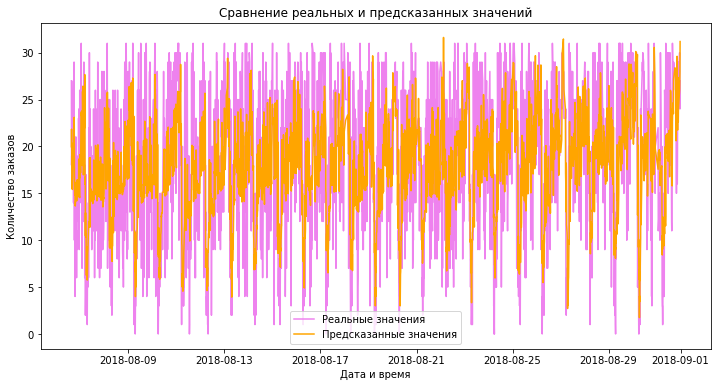

In [45]:
plt.figure(figsize=(12, 6))
plt.plot(X_test.index, y_test, label='Реальные значения', color='violet')

# Построение графика с предсказанными значениями лучшей модели
plt.plot(X_test.index, predictions, label='Предсказанные значения', color='orange')

plt.title('Сравнение реальных и предсказанных значений')
plt.xlabel('Дата и время')
plt.ylabel('Количество заказов')
plt.legend()
plt.show()

#### Итоговый вывод

Исходя из представленных новых данных, мы можем сделать следующие выводы о производительности и качестве моделей линейной регрессии, градиентного бустинга, LightGBM и Dummy Regressor:

**Линейная регрессия:**
- Время обучения: 0.09 минуты
- Время предсказания: 0.25 секунды
- RMSE: 6.621353050644771

**Градиентный бустинг:**
- Время обучения: 0.07 минуты
- Время предсказания: 0.11 секунды
- RMSE: 6.58208262392814

**LightGBM:**
- Время обучения: 0.36 минуты
- Время предсказания: 0.07491564750671387 секунды
- RMSE: 6.611691017251006

**Dummy Regressor:**
- RMSE: 8.178046848007753

**Вывод:** Основываясь на новых данных, Gradient Boosting выглядит как наиболее подходящая модель, учитывая баланс между качеством предсказаний и временем обучения и предсказания. Однако, если важнее минимизация некорректных предсказаний, то лучше себя показывает модель линейной регрессии. В то же время, LightGBM демонстрирует хорошие результаты, но с немного более высоким RMSE по сравнению с Gradient Boosting. Dummy Regressor, как ожидалось, показывает наихудшие результаты среди всех моделей.

В целом, выбор модели зависит от конкретных требований к задаче. Если важнее скорость обучения и предсказания, то Gradient Boosting и линейная регрессия являются хорошими кандидатами. Если же важнее точность предсказаний, то стоит обратить внимание на Gradient Boosting. LightGBM также представляет собой сильную альтернативу, особенно если требуется баланс между скоростью и точностью.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Данные загружены и подготовлены
- [x]  Данные проанализированы
- [x]  Модель обучена, гиперпараметры подобраны
- [x]  Качество моделей проверено, выводы сделаны
- [x]  Значение *RMSE* на тестовой выборке не больше 48